<a href="https://colab.research.google.com/github/doublescoop/NYC-FoodEnvironment/blob/main/get_cd_with_spatial_joins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
!pip install geopandas
!pip install adjustText
#!pip install rtree
!pip install pygeos

!pip uninstall rtree
!brew install spatialindex
!pip install rtree

Found existing installation: Rtree 0.9.7
Uninstalling Rtree-0.9.7:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/Rtree-0.9.7.dist-info/*
    /usr/local/lib/python3.7/dist-packages/Rtree.libs/libspatialindex-bf66e7c6.so.6.1.1
    /usr/local/lib/python3.7/dist-packages/rtree/*
Proceed (y/n)? y
  Successfully uninstalled Rtree-0.9.7
/bin/bash: brew: command not found
  Using cached Rtree-0.9.7-cp37-cp37m-manylinux2010_x86_64.whl (994 kB)


In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import adjustText as aT
import matplotlib.pyplot as plt
from shapely import wkt
import rtree, pygeos

path = "/content/drive/MyDrive/AI for Healthcare Project/data/"

# Load Data

## Community District Data

In [ ]:
# load community district shapefile
district_shapes = gpd.read_file(path+'data_raw/community_districts/nycd_21d/nycd.shp')

#load district attributes
district_attr = pd.read_csv(path+'Source of Truth Community Districts.csv')
district_attr.columns = ['BoroCD','Borough','Name','Is_JIA']

# list of JIAs to exclude
jia_list = [164,226,227,228,355,356,480,481,482,483,484,595] 

#attribute join with district shapefile
districts = district_shapes.merge(district_attr, on='BoroCD')
districts = districts.sort_values(by='BoroCD').reset_index(drop=True)

#set locations in polygons for labels for graphing
districts["center"] = districts["geometry"].centroid
districts_points = districts.copy()
districts_points.set_geometry("center", inplace = True)

## Merged and Normalized Data

In [ ]:
health_outcomes_normed_df = pd.read_csv(path+"/normalized_houtcome.csv")
food_env_normed_df = pd.read_csv(path+"/normalized_foodenvironment_final.csv")

health_outcomes_scaled_df = pd.read_csv(path+"/healthoutcome_newpop.csv")
food_env_scaled_df = pd.read_csv(path+"/foodenvironment_final.csv")

In [ ]:
#add community district
health_outcomes_normed_df.insert(loc=0,column='BoroCD',value=health_outcomes_scaled_df.iloc[:,0])
food_env_normed_df.insert(loc=0,column='BoroCD',value=food_env_scaled_df.iloc[:,0])
health_outcomes_scaled_df.insert(loc=0,column='BoroCD',value=health_outcomes_scaled_df.iloc[:,0])
food_env_scaled_df.insert(loc=0,column='BoroCD',value=food_env_scaled_df.iloc[:,0])

#drop unnamed column
health_outcomes_normed_df = health_outcomes_normed_df.loc[:, ~health_outcomes_normed_df.columns.str.contains('^Unnamed')]
food_env_normed_df = food_env_normed_df.loc[:, ~food_env_normed_df.columns.str.contains('^Unnamed')]
health_outcomes_scaled_df = health_outcomes_scaled_df.loc[:, ~health_outcomes_scaled_df.columns.str.contains('^Unnamed')]
food_env_scaled_df = food_env_scaled_df.loc[:, ~food_env_scaled_df.columns.str.contains('^Unnamed')]

In [ ]:
#attribute join normed data to district shapefiles so we can make plots
food_env_normed_gdf = districts.merge(food_env_normed_df, on='BoroCD')
health_outcomes_normed_gdf = food_env_normed_gdf.merge(health_outcomes_normed_df, on='BoroCD')
district_all_normed_gdf = food_env_normed_gdf.merge(health_outcomes_normed_df, on='BoroCD')

In [ ]:
#attribute join scaled data to district shapefiles so we can make plots
food_env_scaled_gdf = districts.merge(food_env_scaled_df, on='BoroCD')
health_outcomes_scaled_gdf = food_env_scaled_gdf.merge(health_outcomes_scaled_df, on='BoroCD')
district_all_scaled_gdf = food_env_scaled_gdf.merge(health_outcomes_scaled_df, on='BoroCD')

# Functions

In [ ]:
#load csv data missing community districts
def load_point_data(filename, sep=','):
  df = pd.read_csv(path + filename, sep=sep)
  df.head()
  return df

# get geopandas dataframe
    # https://geopandas.org/en/latest/gallery/create_geopandas_from_pandas.html
def to_geopandas(df, use_wkt=False, wkt_col='', lon='Longitude', lat='Latitude', map_epsg=2263):
  if use_wkt:
    #drop rows where there are nans in the longitude or latitude column
    df.dropna(subset=[wkt_col], inplace=True) 
    #create geopandas dataframe from pandas dataframe with string geometry
    df['geometry'] = gpd.GeoSeries.from_wkt(df[wkt_col])
    gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")
  else:
    #drop rows where there are nans in the longitude or latitude column
    df.dropna(subset=[lon,lat], inplace=True) 
    #create geopandas dataframe from pandas dataframe with longitudes and latitudes
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[lon], df[lat], crs="EPSG:4326"))
  
  #project points to community district layer CRS
  return gdf.to_crs(epsg = map_epsg)

# perform spatial join with district data
def spatial_join_with_district(gdf):
  #perform spatial join with community district layer
  joined_df = gdf.sjoin(districts, how="left")
  #drop rows that are in JIAs
  joined_df = joined_df[~joined_df.BoroCD.isin(jia_list)].reset_index(drop=True)
  #drop nan rows
  joined_df = joined_df.dropna(subset=['BoroCD']).reset_index(drop=True)
  return joined_df

#write shape and csv files
def write_files(name, df, sep=','):
  df.to_file(path+"cd_added/"+name+".shp")
  df.to_csv(path+"cd_added/"+name+".csv", sep=sep, index=False)

In [ ]:
#plot map of point locations

def plot_map(layer_df,layer_df2=None,title='',layer_color='blue',layer_color2='blue',markersize=5,figsize=(15,12),print_labels=True):
  #graph base shapes
  ax = districts.plot(figsize = figsize, color="whitesmoke", edgecolor="lightgrey", linewidth=0.5, zorder=1)
  for jia in jia_list:
    districts[districts.BoroCD == jia].plot(color="whitesmoke", edgecolor="lightgrey", hatch="//", ax=ax)
  
  layer_df.plot(ax=ax,marker='o',color=layer_color,markersize=markersize,zorder=2)
  
  if layer_df2 is not None:
    layer_df2.plot(ax=ax,marker='o',color=layer_color2,markersize=markersize,zorder=3)

  #graph text labels
  if print_labels: 
    texts = []
    for x, y, label in zip(districts_points.geometry.x, districts_points.geometry.y, districts_points["BoroCD"]):
        if label not in jia_list:
          texts.append(plt.text(x, y, label, fontsize = 8))
    aT.adjust_text(texts, force_points=0.3, force_text=0.8, expand_points=(1,1), expand_text=(1,1), 
                  arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))
  plt.title(label=title)
  plt.show()

In [ ]:
#plot chloropleth maps given a column argument by which to assign colors

def plot_color_map(df, col_name='', label='', cmap='Blues', figsize=(15,12), print_labels=True):
  
  #graph base shapes
  ax = districts.plot(figsize = figsize, color="whitesmoke", edgecolor="lightgrey", linewidth=0.5, zorder=1)
  for jia in jia_list:
    districts[districts.BoroCD == jia].plot(color="whitesmoke", edgecolor="lightgrey", hatch="//", ax=ax)
  
  #plot colors given column vaues
  df.plot(ax=ax,
          column=col_name,
          legend=True,
          legend_kwds={'label': label,
                       'orientation': "vertical"},
          figsize=figsize,
          cmap=cmap,
          zorder=2)
  
  #overlay district boundary lines
  districts.boundary.plot(edgecolor="lightgrey", linewidth=0.5, ax=ax, zorder=3)
  
  #graph text labels
  if print_labels: 
    texts = []
    for x, y, label in zip(districts_points.geometry.x, districts_points.geometry.y, districts_points["BoroCD"]):
        if label not in jia_list:
          texts.append(plt.text(x, y, label, fontsize = 8))
    aT.adjust_text(texts, force_points=0.3, force_text=0.8, expand_points=(1,1), expand_text=(1,1), 
                  arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))

  plt.show()

# Process and Map Data

# New Section

## Farmers Markets

In [ ]:
filepath = path + "/data_raw/DOHMH_Farmers_Markets.csv"
farm_mkt = pd.read_csv(filepath, sep=';')
farm_mkt_gdf = to_geopandas(farm_mkt)
farmers_market_df = spatial_join_with_district(farm_mkt_gdf)
#write_files('farmers_market_cd',farmers_market_df,sep=';')

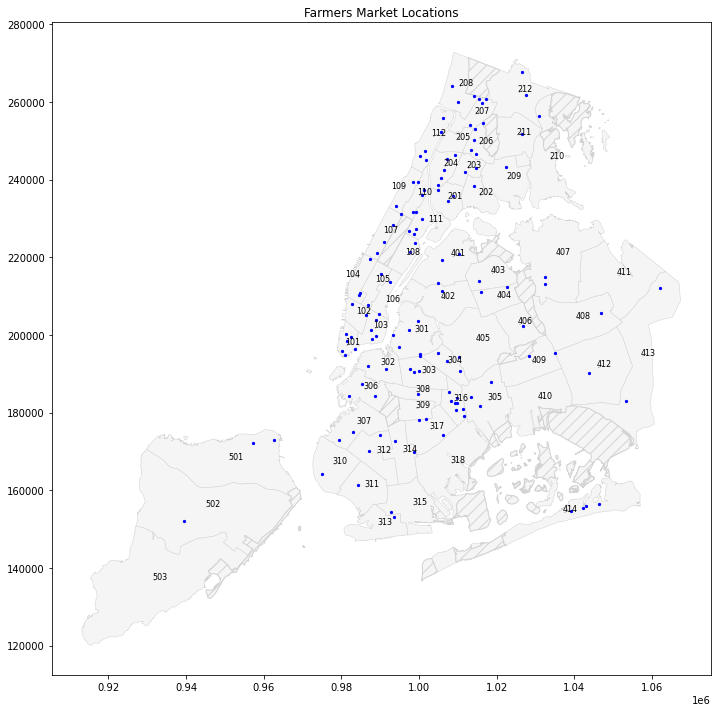

In [ ]:
plot_map(farmers_market_df,
         title='Farmers Market Locations')
plt.show()

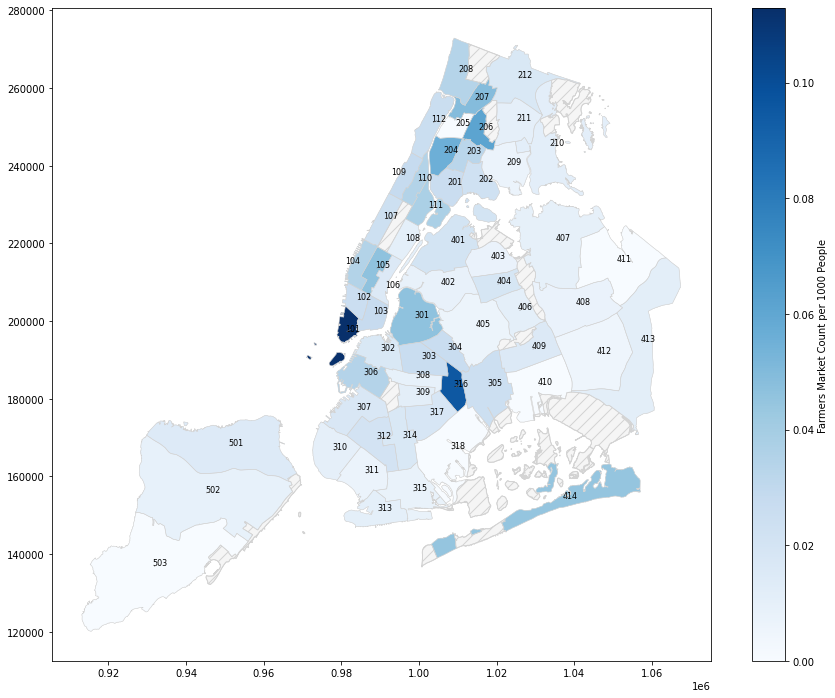

In [ ]:
plot_color_map(df=food_env_scaled_gdf, 
               col_name='Farmers Market', 
               label='Farmers Market Count per 1000 People', 
               figsize=(15,12))

## Community Gardens

In [ ]:
filepath = path + "/data_raw/communitygarden.csv"
garden = pd.read_csv(filepath)
garden_gdf = to_geopandas(garden, use_wkt = True, wkt_col = 'multipolygon')
garden_df = spatial_join_with_district(garden_gdf)
#write_files('community_garden_cd',garden_df)

In [ ]:
#set locations in garden polygons for labels for graphing
garden_df["center"] = garden_df["geometry"].centroid
garden_points = garden_df.copy()
garden_points.set_geometry("center", inplace = True)
print(garden_points.head())

   assemblydist borough  ...  Is_JIA                          center
0            57       B  ...       0   POINT (994811.384 187477.621)
1            60       B  ...       0  POINT (1016322.528 182909.830)
2            50       B  ...       0   POINT (995662.697 205755.859)
3            56       B  ...       0  POINT (1002838.037 185756.461)
4            55       B  ...       0  POINT (1007384.913 181464.397)

[5 rows x 29 columns]


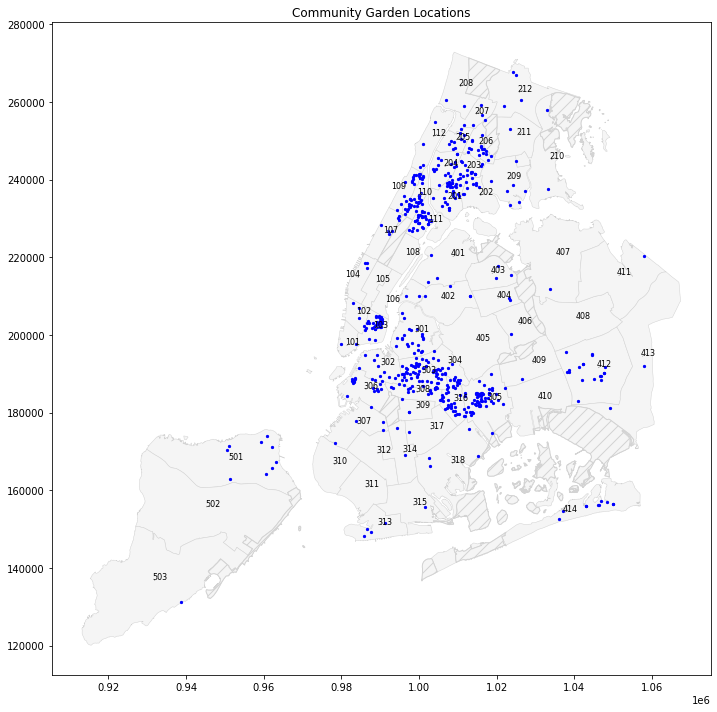

[302 305 301 308 316 304 303 318 306 313 309 307 207 210 201 203 211 209
 205 208 202 204 212 206 501 503 402 409 414 411 412 403 413 401 406 404
 407 110 101 111 109 103 107 102 104 112 315 314 317]


In [ ]:
#plot
plot_map(garden_points, title='Community Garden Locations')
plt.show()
print(pd.unique(garden_points['BoroCD']))

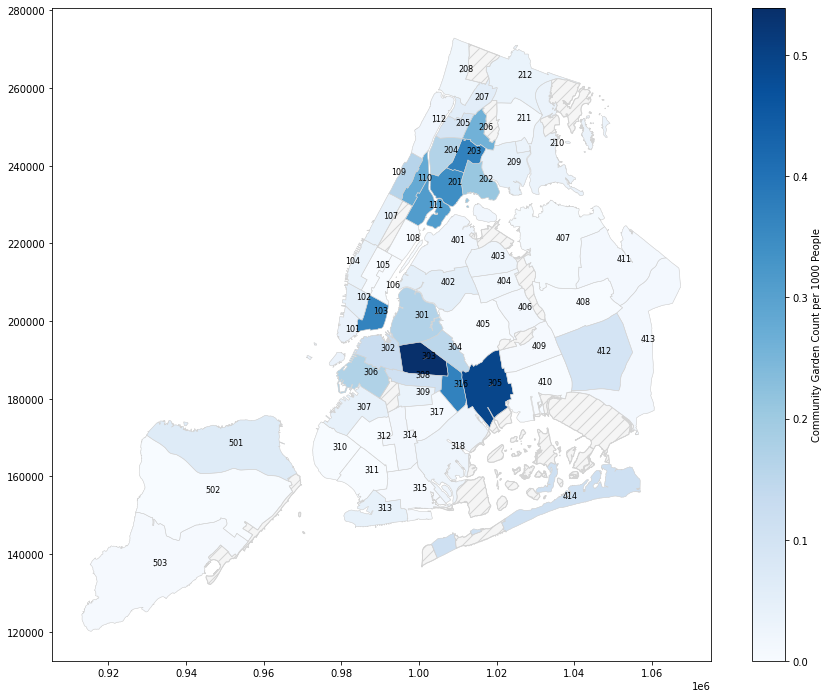

In [ ]:
plot_color_map(df=food_env_scaled_gdf,
               col_name='Community Garden',
               label='Community Garden Count per 1000 People',
               figsize=(15,12))

## Farmers Markets + Community Gardens

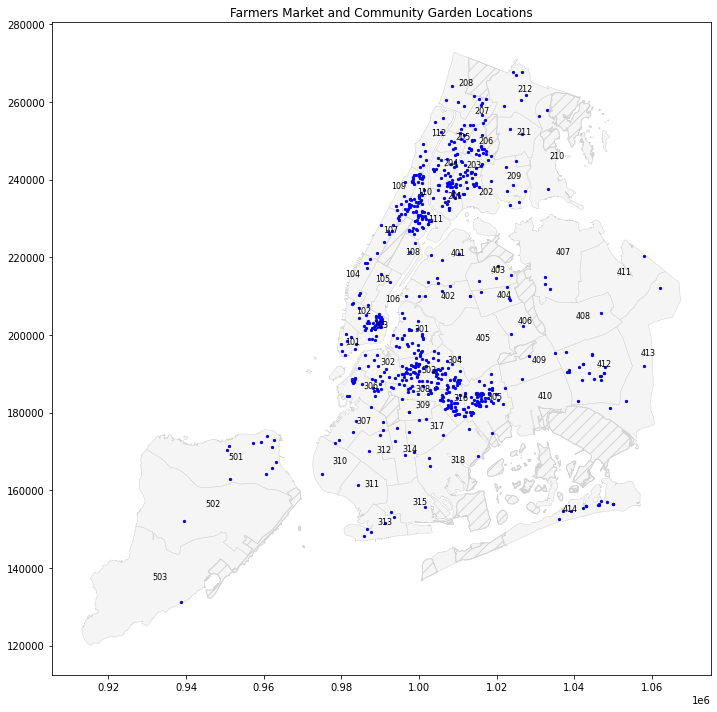

In [ ]:
#plot_map(garden_points)
plot_map(layer_df=farmers_market_df,layer_df2=garden_points,title='Farmers Market and Community Garden Locations')
plt.show()

In [ ]:
food_env_scaled_gdf['combined_farm_mkt_garden'] = food_env_scaled_gdf['Community Garden'] + food_env_scaled_gdf['Farmers Market']

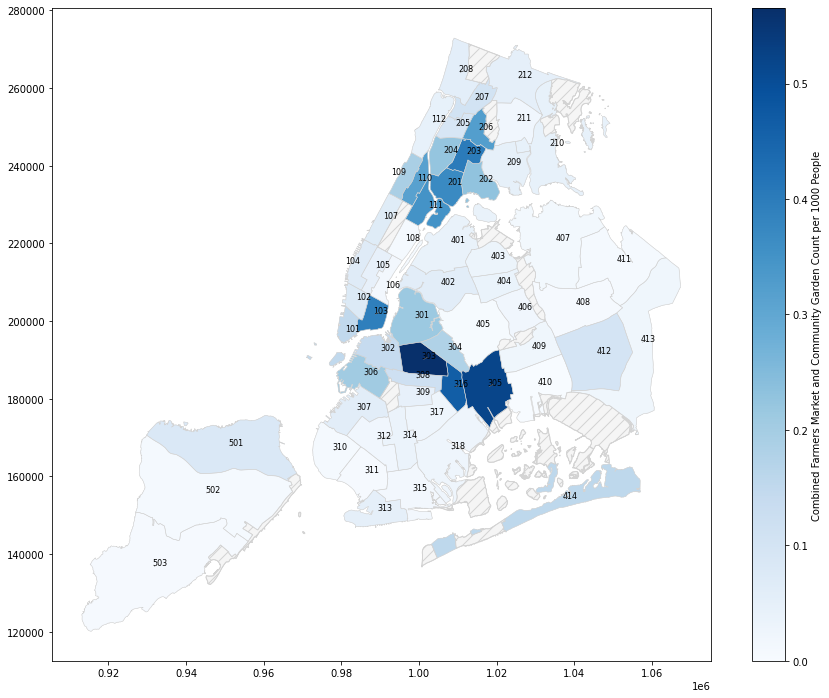

In [ ]:
plot_color_map(df=food_env_scaled_gdf,
               col_name='combined_farm_mkt_garden',
               label='Combined Farmers Market and Community Garden Count per 1000 People',
               figsize=(15,12))

## Recognized Shop Healthy Stores

In [ ]:
filepath = path + "/data_raw/Recognized_Shop_Healthy_Stores.csv"
shop_healthy = pd.read_csv(filepath)
shop_healthy_gdf = to_geopandas(shop_healthy)
shop_healthy_df = spatial_join_with_district(shop_healthy_gdf)
#write_files('shop_healthy_stores_cd',shop_healthy_df)

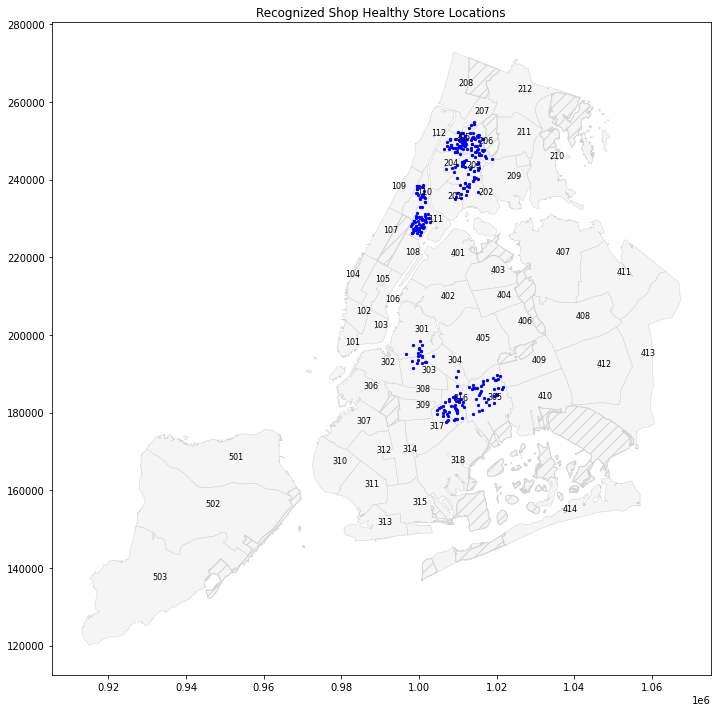

[303 304 301 110 111 205 206 203 202 207 201 305 204 316 317]


In [ ]:
#plot
plot_map(shop_healthy_df,title='Recognized Shop Healthy Store Locations')
plt.show()
print(pd.unique(shop_healthy_df['BoroCD']))

## SNAP Center Locations

In [ ]:
filepath = path + "/data_raw/snap_centers.csv"
snap_c = pd.read_csv(filepath)
snap_c_gdf = to_geopandas(snap_c)
snap_centers_df = spatial_join_with_district(snap_c_gdf)
#write_files('snap_centers_cd',snap_centers_df)

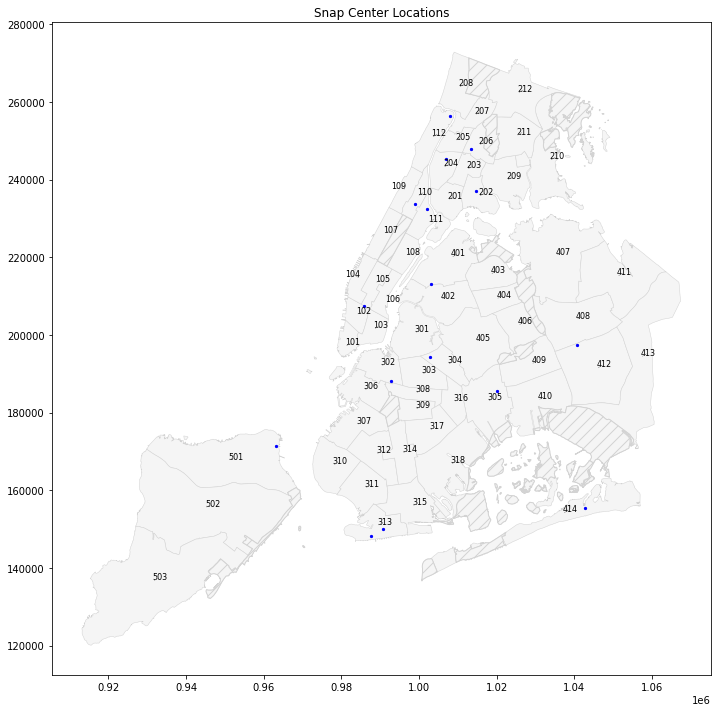

[204 206 202 302 313 305 304 111 112 102 110 412 401 414 501]


In [ ]:
#plot
plot_map(snap_centers_df, title='Snap Center Locations')
plt.show()
print(pd.unique(snap_centers_df['BoroCD']))

## SNAP Accepting Locations

In [ ]:
filepath = path + "/data_raw/snap_accepting_locations.csv"
snap_accept = pd.read_csv(filepath)
snap_accept_gdf = to_geopandas(snap_accept)
snap_accept_locations_df = spatial_join_with_district(snap_accept_gdf)

#write_files('snap_accepting_locations_cd',snap_accept_locations_df)

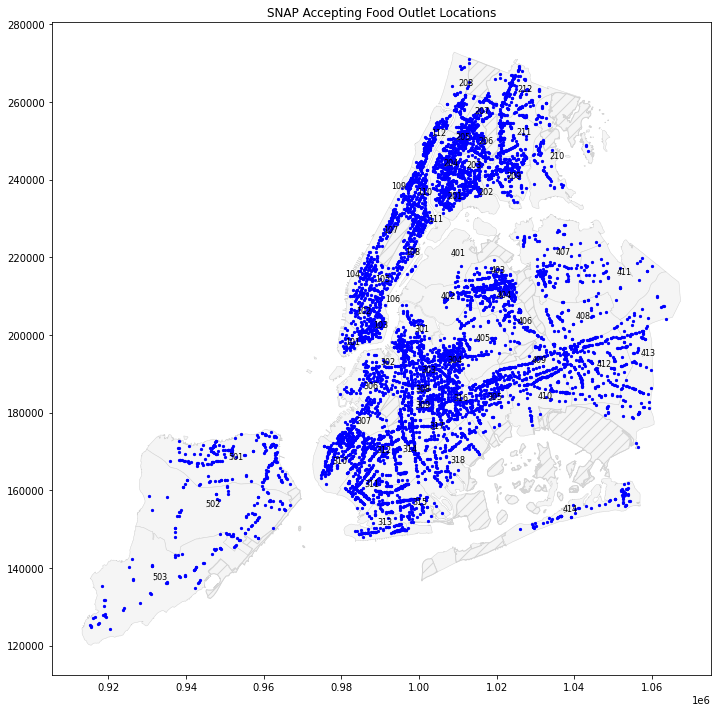

[404. 501. 301. 303. 318. 209. 314. 212. 208. 111. 304. 206. 305. 316.
 103. 312. 202. 201. 108. 410. 313. 205. 412. 109. 317. 409. 204. 502.
 309. 311. 411. 308. 402. 210. 315. 403. 211. 102. 503. 104. 413. 307.
 110. 408. 302. 112. 203. 207. 106. 310. 405. 406. 414. 407. 306. 107.
 105. 101. 401.]


In [ ]:
#plot
plot_map(snap_accept_locations_df, title='SNAP Accepting Food Outlet Locations')
plt.show()
print(pd.unique(snap_accept_locations_df['BoroCD']))

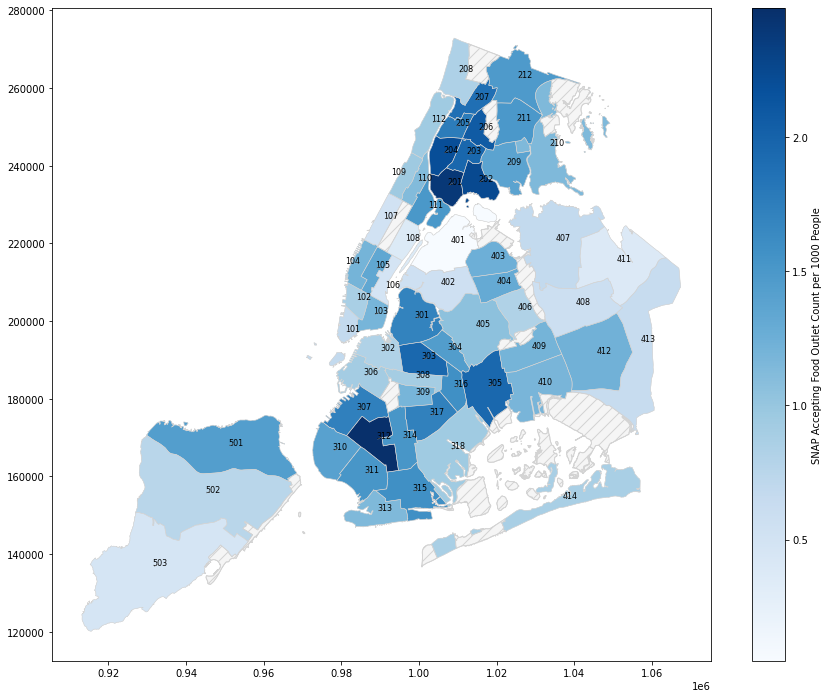

In [ ]:
plot_color_map(df=food_env_scaled_gdf,
               col_name='Snap locations',
               label='SNAP Accepting Food Outlet Count per 1000 People',
               figsize=(15,12))

## SNAP Recipients

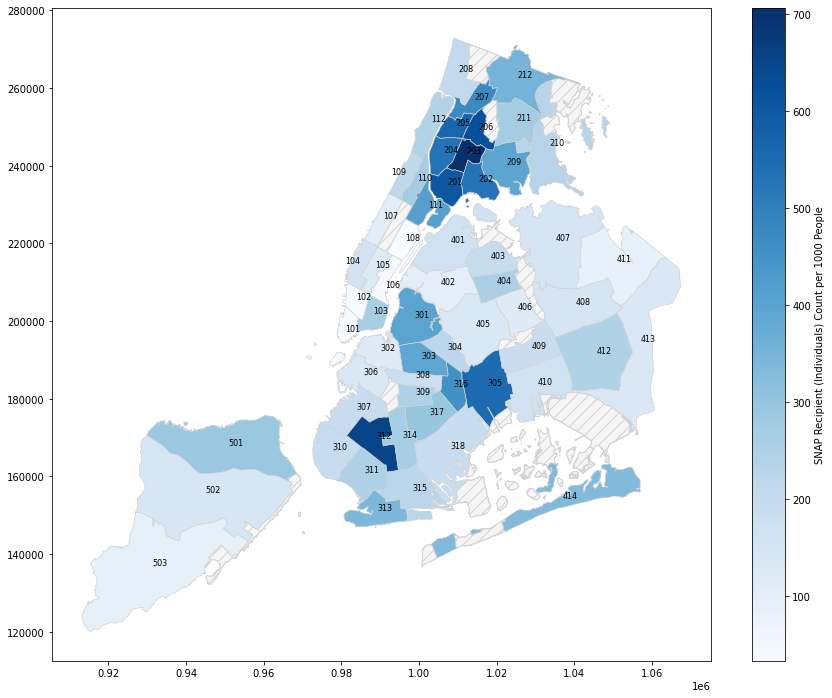

In [ ]:
plot_color_map(df=food_env_scaled_gdf,
               col_name='Snap Recipients',
               label='SNAP Recipient (Individuals) Count per 1000 People',
               figsize=(15,12))

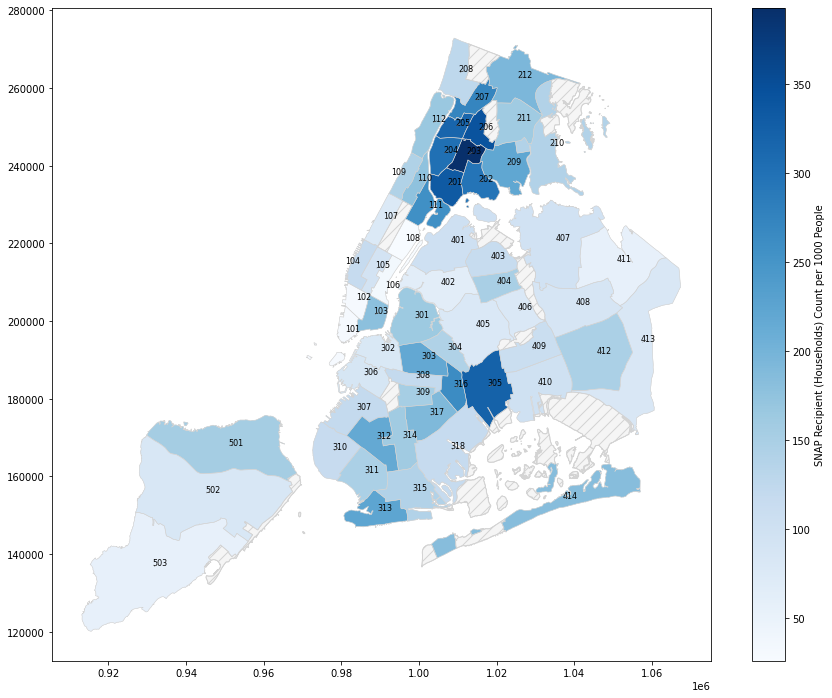

In [ ]:
plot_color_map(df=food_env_scaled_gdf,
               col_name='Snap Households',
               label='SNAP Recipient (Households) Count per 1000 People',
               figsize=(15,12))

## Retail Food Stores

In [ ]:
filepath = path + "/data_raw/Retail_Food_Stores.csv"
retail = pd.read_csv(filepath)
retail_gdf = to_geopandas(retail, use_wkt = True, wkt_col = 'Georeference')
retail_df = spatial_join_with_district(retail_gdf)
#write_files('retail_food_stores_cd',retail_df)

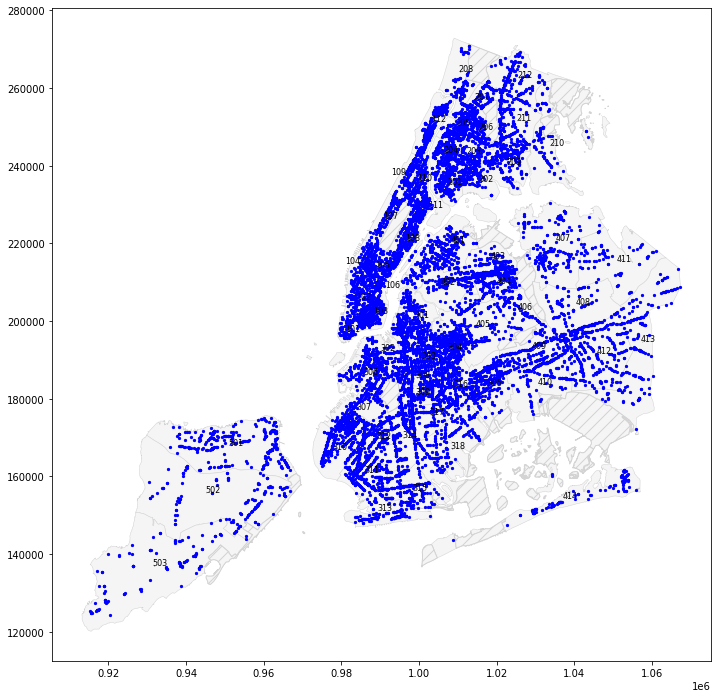

[403. 301. 303. 317. 410. 311. 111. 407. 312. 307. 313. 501. 305. 315.
 401. 314. 209. 207. 101. 302. 409. 318. 308. 212. 310. 201. 103. 502.
 202. 203. 306. 405. 211. 316. 411. 206. 408. 205. 105. 412. 112. 104.
 404. 102. 110. 109. 402. 304. 210. 503. 107. 414. 204. 413. 108. 309.
 208. 106. 406.]


In [ ]:
#plot
plot_map(retail_df)
plt.show()
print(pd.unique(retail_df['BoroCD']))

In [ ]:
filepath = path + "/retailfoodscaled.csv"
retail_scaled_df = pd.read_csv(filepath)
# retail_scaled_df.rename(columns={'Community District':'BoroCD'},inplace=True)
# retail_scaled_df = retail_scaled_df.loc[:, ~retail_scaled_df.columns.str.contains('^Unnamed')]
# retail_scaled_gdf = districts.merge(retail_scaled_df, on='BoroCD')

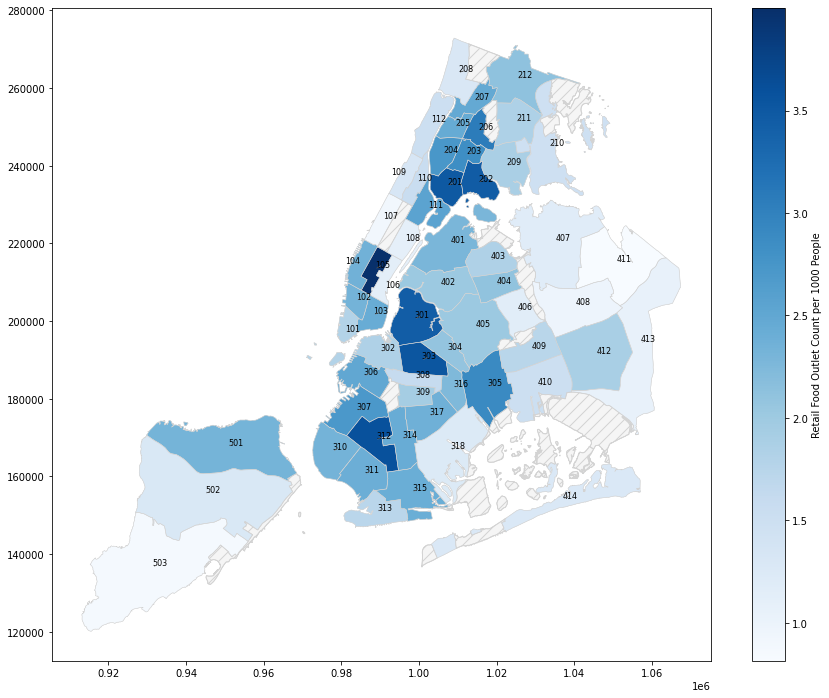

In [ ]:
plot_color_map(df=retail_scaled_gdf,
               col_name='RetailFoodper1000',
               label='Retail Food Outlet Count per 1000 People',
               figsize=(15,12))

## Bodega-Supermarket Ratio

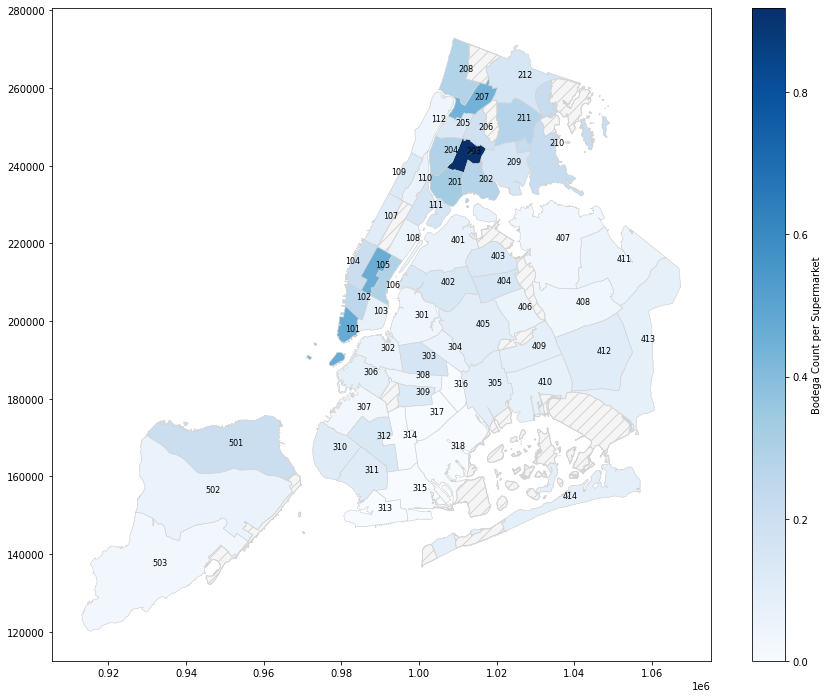

In [ ]:
plot_color_map(df=food_env_scaled_gdf,
               col_name='Ratio_Bodega_Supermarket',
               label='Bodega Count per Supermarket',
               figsize=(15,12))

## Farmers Market-Retail Food Outlet Ratio

1.   List item

1.   List item
2.   List item


2.   List item



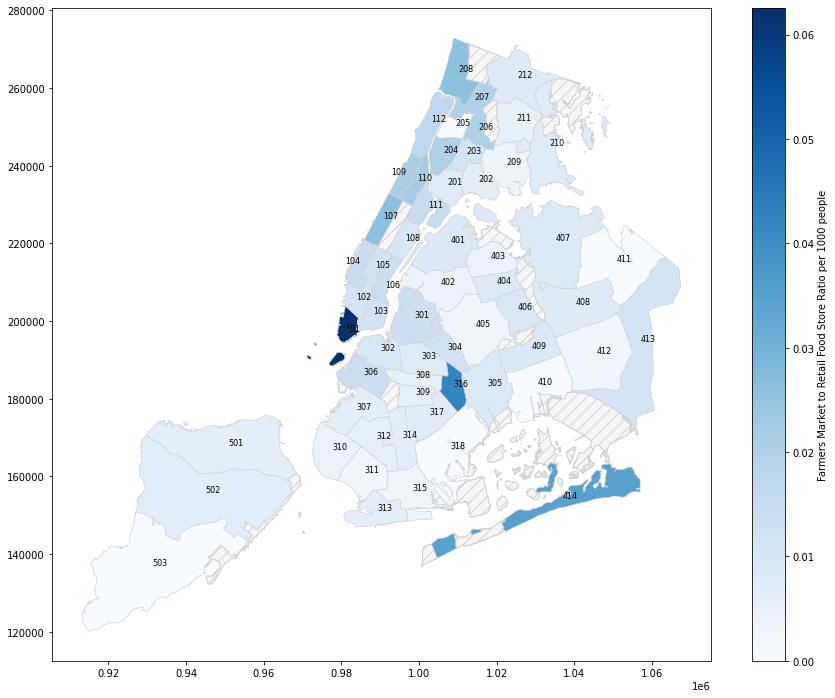

In [ ]:
plot_color_map(df=food_env_scaled_gdf,
               col_name='FMperRetailFood',
               label='Farmers Market to Retail Food Store Ratio per 1000 people',
               figsize=(15,12))

## Community Garden-Retail Food Outlet Ratio

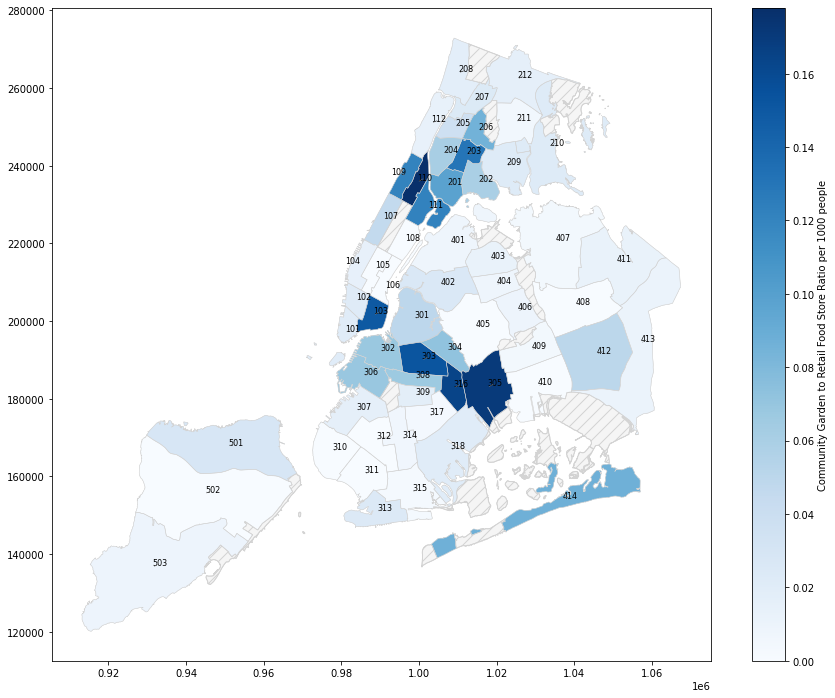

In [ ]:
plot_color_map(df=food_env_scaled_gdf,
               col_name='CMperRetailFooD',
               label='Community Garden to Retail Food Store Ratio per 1000 people',
               figsize=(15,12))

## SNAP Accepting Locations - Retail Food Outlet Ratio

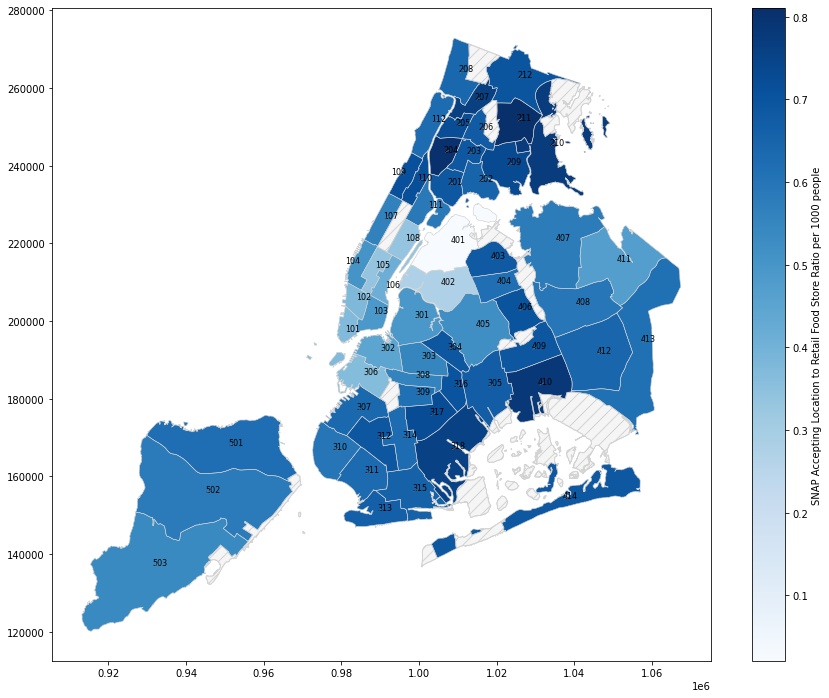

In [ ]:
plot_color_map(df=food_env_scaled_gdf,
               col_name='SNAPperRetailFood',
               label='SNAP Accepting Location to Retail Food Store Ratio per 1000 people',
               figsize=(15,12))

# Scatter Plots and Histograms

In [ ]:
features = ['Farmers Market', 'Community Garden',
       'Snap Recipients', 'Snap Households', 'Snap locations',
       'Ratio_Bodega_Supermarket', 'Retail Food', 'FMperRetailFood',
       'CMperRetailFooD', 'SNAPperRetailFood']
feature_desc = ['Normalized Farmers Market Count Per Thousand', 'Normalized Community Garden Count Per Thousand',
       'Normalized SNAP Recipients (Individual) Per Thousand', 'Normalized SNAP Recipients (Household) Per Thousand',
       'Normalized SNAP Accepting Location Count Per Thousand', 'Normalized Bodega-to-Supermarket Ratio',
       'Normalized Retail Food Outlet Count Per Thousand', 'Normalized Farmers Markets Count Per Thousand',
       'Normalized Community Garden Count Per Thousand', 
       'Normalized SNAP Accepting Location Count per Retail Food Count per Thousand']

outcomes = ['Obesity', 'Diabetes', 'Avoidable_Adult_Hosp']
outcome_desc = ['Normalized Obesity Rate', 'Normalized Diabetes Rate', 
                'Normalized Avoidable Adult Hospitalization Rate']

## Scatter Plots

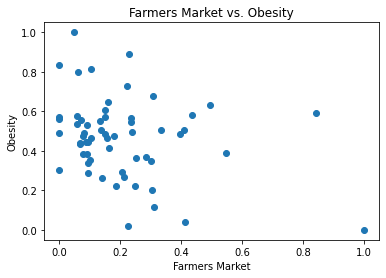

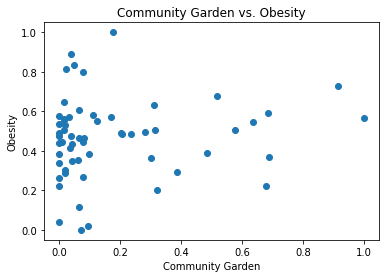

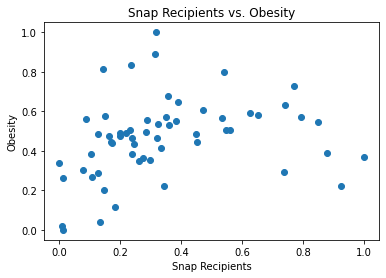

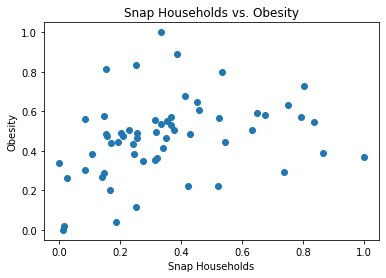

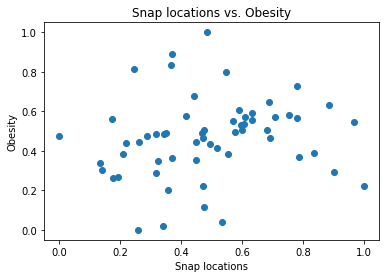

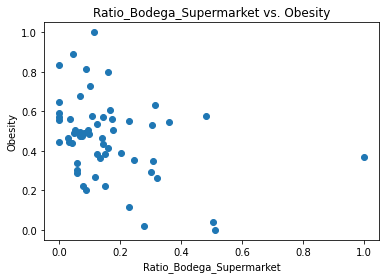

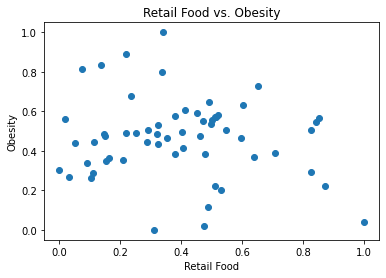

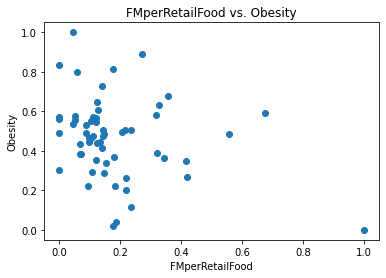

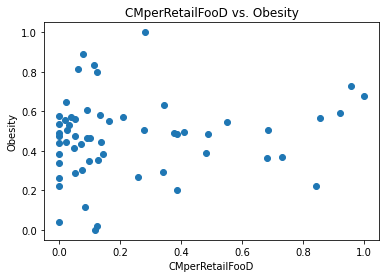

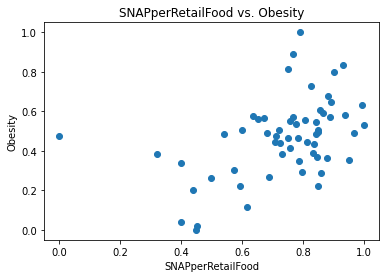

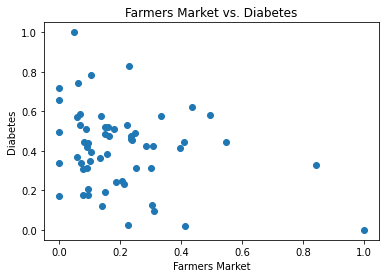

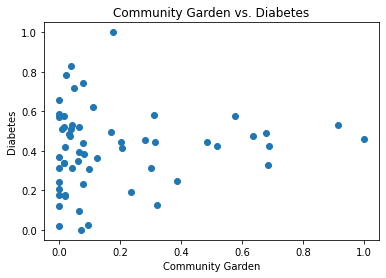

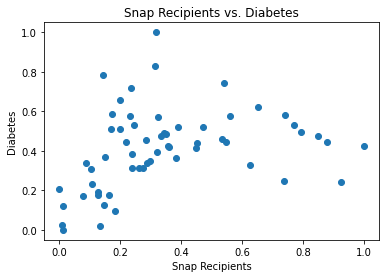

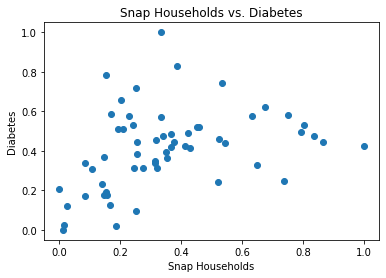

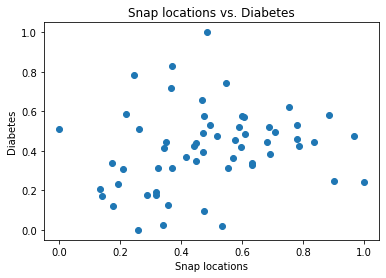

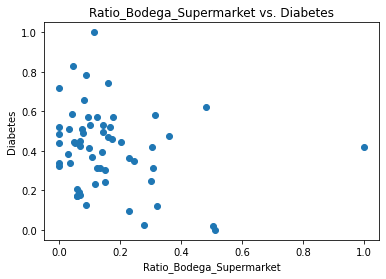

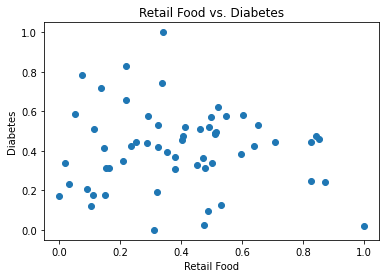

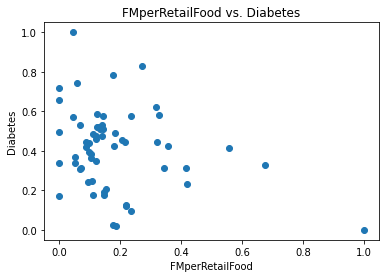

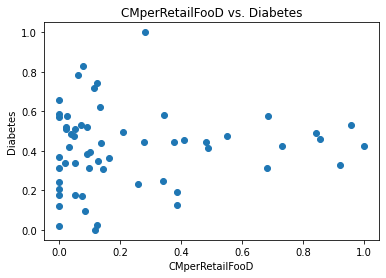

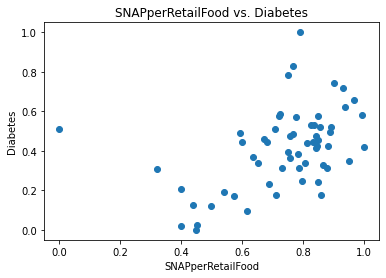

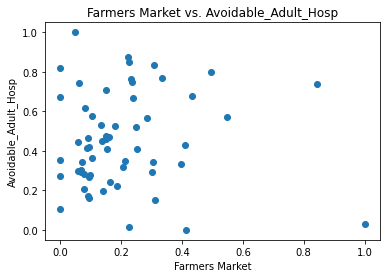

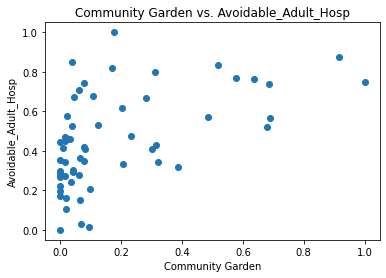

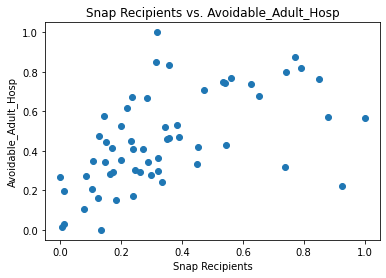

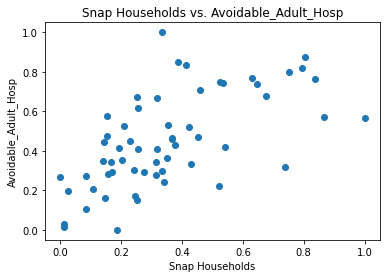

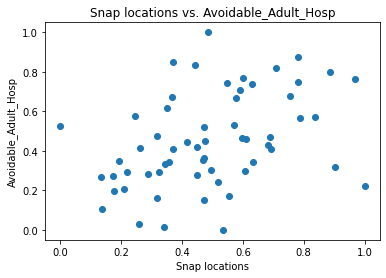

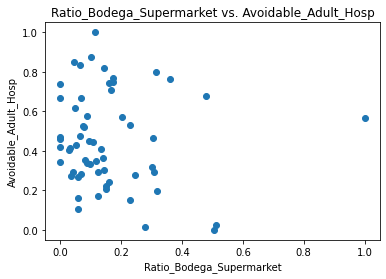

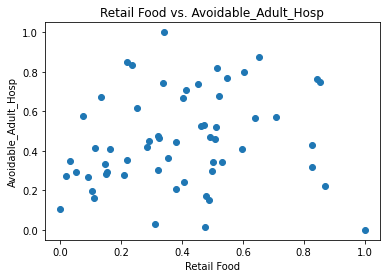

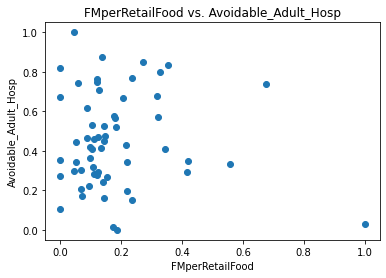

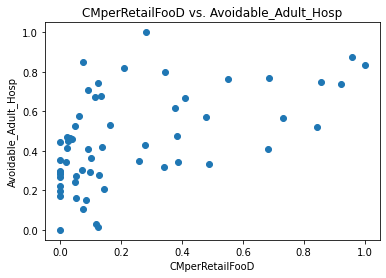

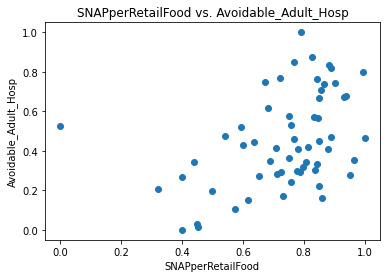

In [ ]:
features = ['Farmers Market', 'Community Garden',
       'Snap Recipients', 'Snap Households', 'Snap locations',
       'Ratio_Bodega_Supermarket', 'Retail Food', 'FMperRetailFood',
       'CMperRetailFooD', 'SNAPperRetailFood']

outcomes = ['Obesity', 'Diabetes', 'Avoidable_Adult_Hosp']
#other_outcomes = ['Self_Rep_Health', 'Fruit_Veg', 'Physical_Activity']

for outcome in outcomes:
  for feature in features:
    # fig, (ax1, ax2) = plt.subplots(1,2)
    # ax1.scatter(district_all_scaled_gdf[feature],district_all_scaled_gdf[outcome])
    # ax2.scatter(district_all_normed_gdf[feature],district_all_normed_gdf[outcome])
    # ax1.set(xlabel='Scaled '+feature, ylabel='Scaled '+outcome)
    # ax2.set(xlabel='Normalized '+feature, ylabel='Normalized '+outcome)
    # fig.suptitle(feature+' vs. '+outcome)

    #not much difference between scaled vs normalized, so just plot the normalized
    plt.scatter(district_all_normed_gdf[feature],district_all_normed_gdf[outcome])
    plt.title(feature+' vs. '+outcome)
    plt.xlabel(feature)
    plt.ylabel(outcome)
    plt.show()
    print('\n')

## Histogram

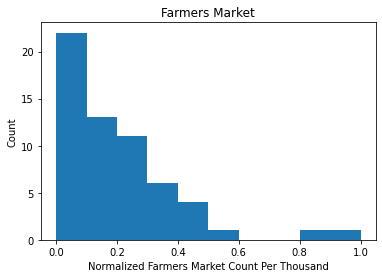

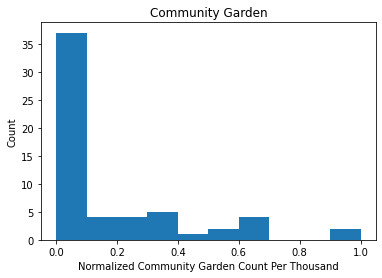

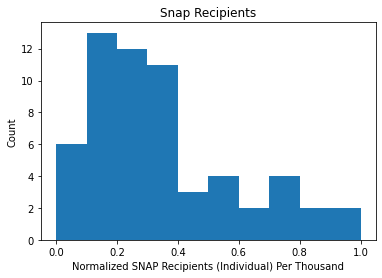

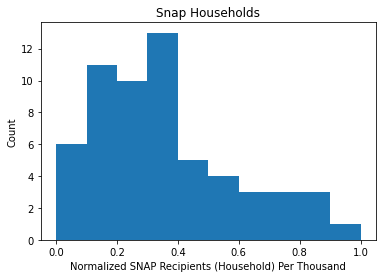

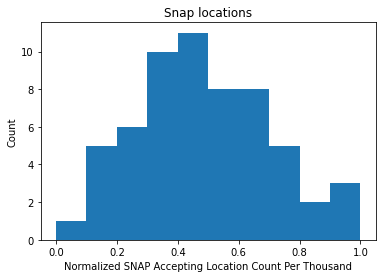

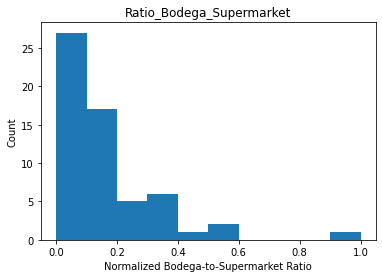

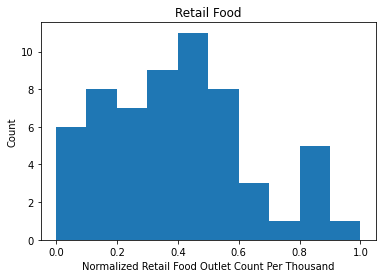

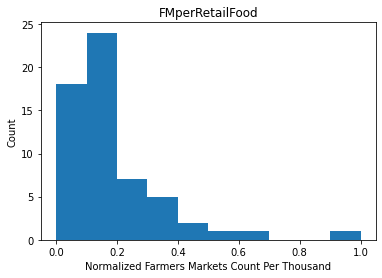

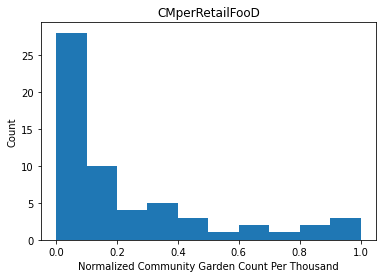

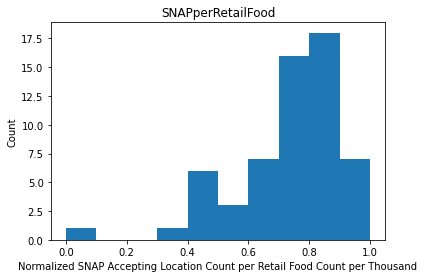

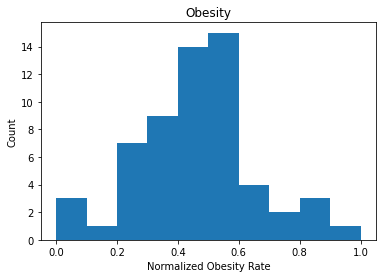

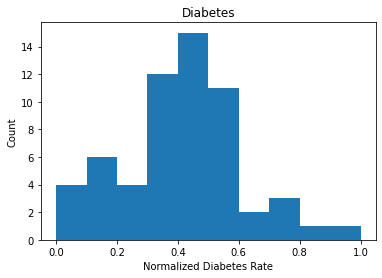

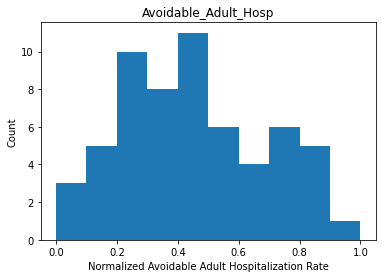

In [ ]:
for feature,desc in zip(features,feature_desc):
  plt.hist(district_all_normed_gdf[feature])
  plt.title(feature)
  plt.xlabel(desc)
  plt.ylabel('Count')
  plt.show()
  print('\n')

for outcome,desc in zip(outcomes,outcome_desc):
  plt.hist(district_all_normed_gdf[outcome])
  plt.title(outcome)
  plt.xlabel(desc)
  plt.ylabel('Count')
  plt.show()
  print('\n')